<a href="https://colab.research.google.com/github/Tarun280896/DeepLearning/blob/master/NLP/sarcasm_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2021-05-21 11:58:08--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2021-05-21 11:58:08 (107 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [2]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [5]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [6]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [17]:

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get('accuracy')>0.99:
      print('\nAchieved 99% accuracy so training cancelled')
      self.model.stop_training = True

In [8]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.6673 - accuracy: 0.5853 - val_loss: 0.5937 - val_accuracy: 0.6941
Epoch 2/30
625/625 - 2s - loss: 0.4422 - accuracy: 0.8242 - val_loss: 0.3894 - val_accuracy: 0.8377
Epoch 3/30
625/625 - 2s - loss: 0.3164 - accuracy: 0.8745 - val_loss: 0.3535 - val_accuracy: 0.8526
Epoch 4/30
625/625 - 2s - loss: 0.2645 - accuracy: 0.8963 - val_loss: 0.3434 - val_accuracy: 0.8566
Epoch 5/30
625/625 - 2s - loss: 0.2293 - accuracy: 0.9120 - val_loss: 0.3499 - val_accuracy: 0.8486
Epoch 6/30
625/625 - 2s - loss: 0.2013 - accuracy: 0.9237 - val_loss: 0.3474 - val_accuracy: 0.8538
Epoch 7/30
625/625 - 2s - loss: 0.1798 - accuracy: 0.9318 - val_loss: 0.3569 - val_accuracy: 0.8536
Epoch 8/30
625/625 - 2s - loss: 0.1607 - accuracy: 0.9413 - val_loss: 0.3730 - val_accuracy: 0.8515
Epoch 9/30
625/625 - 2s - loss: 0.1463 - accuracy: 0.9461 - val_loss: 0.3838 - val_accuracy: 0.8538
Epoch 10/30
625/625 - 2s - loss: 0.1316 - accuracy: 0.9549 - val_loss: 0.4035 - val_accuracy: 0.8511

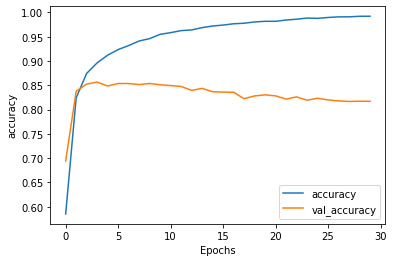

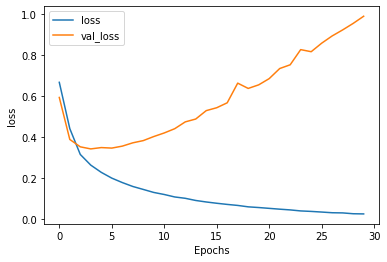

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Using LSTM

In [13]:
lstm_model = tf.keras.models.Sequential([tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
                                         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                                         tf.keras.layers.Dense(24,activation='relu'),
                                         tf.keras.layers.Dense(1,activation='sigmoid')])

In [18]:
lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               41472     
_________________________________________________________________
dense_4 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 204,593
Trainable params: 204,593
Non-trainable params: 0
_________________________________________________________________


In [22]:
num_epochs = 30
history = lstm_model.fit(training_padded, training_labels,epochs=50,callbacks=[myCallback()], validation_data=(testing_padded, testing_labels))

Epoch 1/50
625/625 [==============================] - 48s 77ms/step - loss: 0.2170 - accuracy: 0.9135 - val_loss: 0.3545 - val_accuracy: 0.8475
Epoch 2/50
625/625 [==============================] - 47s 75ms/step - loss: 0.1535 - accuracy: 0.9439 - val_loss: 0.3986 - val_accuracy: 0.8432
Epoch 3/50
625/625 [==============================] - 47s 75ms/step - loss: 0.1123 - accuracy: 0.9609 - val_loss: 0.4529 - val_accuracy: 0.8377
Epoch 4/50
625/625 [==============================] - 47s 75ms/step - loss: 0.0773 - accuracy: 0.9736 - val_loss: 0.5129 - val_accuracy: 0.8395
Epoch 5/50
625/625 [==============================] - 47s 75ms/step - loss: 0.0479 - accuracy: 0.9845 - val_loss: 0.6317 - val_accuracy: 0.8353
Epoch 6/50
625/625 [==============================] - 48s 76ms/step - loss: 0.0326 - accuracy: 0.9898 - val_loss: 0.8375 - val_accuracy: 0.8265
Epoch 7/50
625/625 [==============================] - 48s 77ms/step - loss: 0.0220 - accuracy: 0.9925 - val_loss: 0.9107 - val_accuracy:

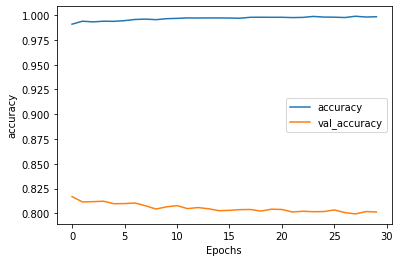

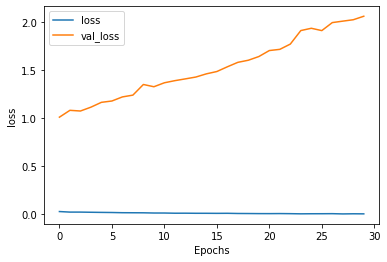

In [16]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")